# Fake News websites data analysis

Will use data downloaded from CrowdTangle's "historical data" feature rather than making multiple requests to the API. The latter option would end up taking longer due to API limitations.

The data was downloaded on several .csv files, saved on `./data/in`.


Time period for the analysis:
* Start - 2019-01-01
* End - 2021-03-27

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
import timeit
import time
import glob
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

## Get list of pages on each category

Given that the .csv files generated by CrowdTangle do not specify from which list they come from, it will be necessary to make API calls go get the IDs of pages related to each list.

The lists are:

* 'least-biased' : '1525935'
* 'conspiracy-pseudoscience' : '1525936'
* 'pro-science' : '1525937'

In [2]:
lists = {
    'least-biased' : '1525935',
    'conspiracy-pseudoscience' : '1525936',
    'pro-science' : '1525937'
}

In [3]:
token = open('./ctoken').read()

In [4]:
def generate_account_list_url(listid, token=token):
    '''
    Generates the API URL for the get request with the lists of accounts.
    
    ARGS:
    ListId = The id of the list for which to retrieve accounts. This is provided as a path variable in the URL
    Token = API Token
    
    Returns:
    STR - CrowdTangle API URL, for getting IDs of accounts in a list
    '''
    return 'https://api.crowdtangle.com/lists/{}/accounts?token={}&count=100'.format(listid, token)

In [5]:
platformid_to_list = dict()

In [6]:
for listname, listid in lists.items():
    print(listname)
    page = 0
    nextpage = True
    url =  generate_account_list_url(listid)
    while nextpage:
        page += 1
        print('DOWNLOADING PAGE', page)
        
        re = requests.get(url)

        for account in re.json()['result']['accounts']:
            platformid_to_list[account['platformId']] = listname
            
        if 'nextPage' in re.json()['result']['pagination']:
            url = re.json()['result']['pagination']['nextPage']
            time.sleep(10)
        else:
            nextpage = False

least-biased
DOWNLOADING PAGE 1
DOWNLOADING PAGE 2
DOWNLOADING PAGE 3
DOWNLOADING PAGE 4
conspiracy-pseudoscience
DOWNLOADING PAGE 1
DOWNLOADING PAGE 2
pro-science
DOWNLOADING PAGE 1
DOWNLOADING PAGE 2


## Creates and cleans DF

Data was downloaded on several .csv files. Merge them into one single DF.

*Note: yes, this is will probably use up a lot of RAM. I have recently bought 32gb, though, so I am going to use it ;)*

In [7]:
path = './data/in'
files = glob.glob(path + '/*.csv')

df_list = []

for filename in files:
    df = pd.read_csv(filename, index_col=None, low_memory=False, dtype={'Facebook Id' : str})
    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)

### Cleaning

Remove unnecessary columns and pages with under 100 average followers, the same threshold used by NYU researchers for [this article](https://medium.com/cybersecurity-for-democracy/far-right-news-sources-on-facebook-more-engaging-e04a01efae90).

In [8]:
df.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'Link Text',
       'Description', 'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )'],
      dtype='object')

In [9]:
columns_to_drop = ['User Name', 'Page Category', 'Page Admin Top Country', 'Page Description', 'Sponsor Id',
                   'Page Created','Likes at Posting', 'Post Created Date', 'Post Created Time', 'Video Length',
                   'Total Interactions', 'Video Share Status', 'Is Video Owner?', 'Post Views', 'Total Views For All Crossposts',
                   'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )']

df.drop(columns_to_drop, axis = 1, inplace=True)

# TURN ALL REACTIONS INTO ONE COLUMN
df['Reactions'] = df[['Likes', 'Love', 'Wow', 'Haha', 'Sad', 'Angry','Care']].sum(axis=1)

columns_to_drop = ['Likes', 'Love', 'Wow', 'Haha', 'Sad', 'Angry','Care']
df.drop(columns_to_drop, axis = 1, inplace=True)

'''
This part will recreate the Total Interactions column.
My computer is in PT-BR and CrowdTangle uses commas in their decimal separator.
The workaround for this is so dramatic that it is easier to just recreate the column.
'''
df['Total Interactions'] = df[['Reactions', 'Comments', 'Shares']].sum(axis=1)

#### Lists pages below the 100 avg. followers threshold

In [10]:
grouped_by_followers = df.groupby('Facebook Id').agg({'Followers at Posting' : 'mean'})
grouped_by_followers['Followers at Posting'].min()

175.28947368421052

None of the pages fall under the threshold, so no action is necessary.

### Renames columns

To avoid mistakes later, all column names will be turned to lower case and will have no spaces.

In [11]:
column_names = list()
for c in df.columns:
    column_names.append(c.lower().replace(' ', '_'))

df.columns = column_names

### Add category column

In [12]:
def check_category(facebookid,
                   platformid_to_list=platformid_to_list):
    '''
    Checks the Facebook ID and finds it in the dictionary with
    category names. Returns category.
    
    ARGS:
    facebookid - STR - id to be found
    platformid_to_list - List of IDs and their categories
    
    RETURN:
    'least-biased'|'conspiracy-pseudoscience'|'pro-science'
    '''
    return platformid_to_list[facebookid]

In [13]:
df['category'] = df['facebook_id'].apply(lambda x: check_category(x))

# CHECKS FOR ERRORS
df[df['category'].isna()]

,page_name,facebook_id,followers_at_posting,post_created,type,comments,shares,total_views,url,message,link,final_link,image_text,link_text,description,sponsor_name,sponsor_category,reactions,total_interactions,category


### Removes duplicates

In [14]:
len(df)

11867144

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
len(df)

6372118

### Converts post creation date to datetime

In [17]:
df['post_created'] = pd.to_datetime(df['post_created'])

C:\Users\rapha\OneDrive\python\science-fakenews-facebook\env\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\rapha\OneDrive\python\science-fakenews-facebook\env\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


### Removes pages not available after 2021

The analysis will focus on the trends for the past few months, so it makes no sense to include in the analysis pages that have no data after 2021.

In [18]:
# CHECKS IF THERE ARE PAGES THAT LACK 2021 DATA

posts_per_year = df.groupby('facebook_id').resample('Y', on='post_created').count()[['facebook_id']]
posts_per_year.columns = ['count']
posts_per_year.reset_index()['post_created'].value_counts()

2020-12-31    565
2019-12-31    559
2021-12-31    546
Name: post_created, dtype: int64

In [19]:
january_first_21 = datetime.strptime('2021-01-01','%Y-%m-%d')

pages_before_2021 = df[df['post_created'] < january_first_21]['facebook_id'].unique()
pages_in_2021 = df[df['post_created'] > january_first_21]['facebook_id'].unique()

# GENERATES A LIST OF PAGES THAT ARE NOT IN 2021
pages_to_remove = list(np.setdiff1d(pages_before_2021, pages_in_2021))

In [20]:
df = df[~df['facebook_id'].isin(pages_to_remove)].reset_index(drop=True)

## Analysis

In [21]:
df.head()

,page_name,facebook_id,followers_at_posting,post_created,type,comments,shares,total_views,url,message,link,final_link,image_text,link_text,description,sponsor_name,sponsor_category,reactions,total_interactions,category
0,Jesus Daily,70630972354,32790425.0,2019-02-01 23:50:00,Link,21,98,0,https://www.facebook.com/JesusDaily/posts/1015...,3-week-old baby stops breathing after 2 hour c...,http://www.jesusdaily.com/3-week-old-baby-stop...,https://www.jesusdaily.com/3-week-old-baby-sto...,NaN,3-week-old baby stops breathing after 2 hour c...,Every parent should read this.,NaN,NaN,303,422,conspiracy-pseudoscience
1,Jesus Daily,70630972354,32790425.0,2019-02-01 23:40:00,Link,10,39,0,https://www.facebook.com/JesusDaily/posts/1015...,"Girl Belts Out 80-Year-Old Song, The Voice Jud...",http://www.jesusdaily.com/girl-belts-out-80-ye...,https://www.jesusdaily.com/girl-belts-out-80-y...,NaN,"Girl Belts Out 80-Year-Old Song, The Voice Jud...",She hadn't even finished the first word to the...,NaN,NaN,493,542,conspiracy-pseudoscience
2,Thinking Humanity,673094636084762,6349593.0,2019-02-01 23:35:00,Link,33,359,0,https://www.facebook.com/ThinkingHumanity/post...,As an excavator crashed down on a pile of cut ...,https://www.thinkinghumanity.com/2018/07/heart...,NaN,NaN,Heartbreaking Footage of Orangutan Trying to F...,As an excavator crashed down on a pile of cut ...,NaN,NaN,1330,1722,conspiracy-pseudoscience
3,Ancient Origins,530869733620642,654152.0,2019-02-01 23:30:07,Photo,23,172,0,https://www.facebook.com/ancientoriginsweb/pos...,"San Gens Necropolis, #Portugal www.ancient-ori...",https://www.facebook.com/ancientoriginsweb/pho...,NaN,NaN,Timeline Photos,NaN,NaN,NaN,410,605,conspiracy-pseudoscience
4,Collective Evolution,131929868907,5164323.0,2019-02-01 23:30:00,Photo,118,8763,0,https://www.facebook.com/CollectiveEvolutionPa...,NaN,https://www.facebook.com/CollectiveEvolutionPa...,NaN,"When you replace ""why is this happening to me""...",NaN,NaN,NaN,NaN,5205,14086,conspiracy-pseudoscience


In [22]:
df.columns

Index(['page_name', 'facebook_id', 'followers_at_posting', 'post_created',
       'type', 'comments', 'shares', 'total_views', 'url', 'message', 'link',
       'final_link', 'image_text', 'link_text', 'description', 'sponsor_name',
       'sponsor_category', 'reactions', 'total_interactions', 'category'],
      dtype='object')

In [23]:
df.dtypes

page_name                       object
facebook_id                     object
followers_at_posting           float64
post_created            datetime64[ns]
type                            object
comments                         int64
shares                           int64
total_views                      int64
url                             object
message                         object
link                            object
final_link                      object
image_text                      object
link_text                       object
description                     object
sponsor_name                    object
sponsor_category                object
reactions                        int64
total_interactions               int64
category                        object
dtype: object

In [24]:
df.describe()

,followers_at_posting,comments,shares,total_views,reactions,total_interactions
count,6.284795e+06,6.363732e+06,6.363732e+06,6.363732e+06,6.363732e+06,6.363732e+06
mean,3.396084e+06,1.029912e+02,1.583277e+02,2.243504e+04,5.440192e+02,8.053382e+02
std,5.991632e+06,7.399901e+02,2.073861e+03,9.913297e+05,5.670405e+03,7.223245e+03
min,1.590000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.874110e+05,1.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,1.600000e+01
50%,7.472880e+05,6.000000e+00,8.000000e+00,0.000000e+00,4.800000e+01,7.300000e+01
75%,4.200781e+06,4.500000e+01,3.900000e+01,0.000000e+00,2.000000e+02,3.240000e+02
max,3.672279e+07,4.817870e+05,1.993925e+06,5.193480e+08,2.390346e+06,2.654643e+06


#### Data distribution

Plots histograms for the pages average of followers and interactions

In [25]:
df_page_average = df.groupby(['category','facebook_id'], as_index=False).mean()
df_page_average.head()

,category,facebook_id,followers_at_posting,comments,shares,total_views,reactions,total_interactions
0,conspiracy-pseudoscience,100044277467057,3.988466e+04,3.614879,14.034413,1623.033401,39.942308,57.591599
1,conspiracy-pseudoscience,100044473864739,2.442477e+06,12.409693,48.892331,89809.019985,104.042468,165.344492
2,conspiracy-pseudoscience,100045211009413,1.723180e+05,50.748869,25.852941,3210.780543,232.264706,308.866516
3,conspiracy-pseudoscience,100046721091106,1.548979e+05,32.628925,275.728830,199.847764,571.884872,880.242626
4,conspiracy-pseudoscience,100050510648657,1.219202e+04,22.824153,51.213983,4.540254,166.680085,240.718220


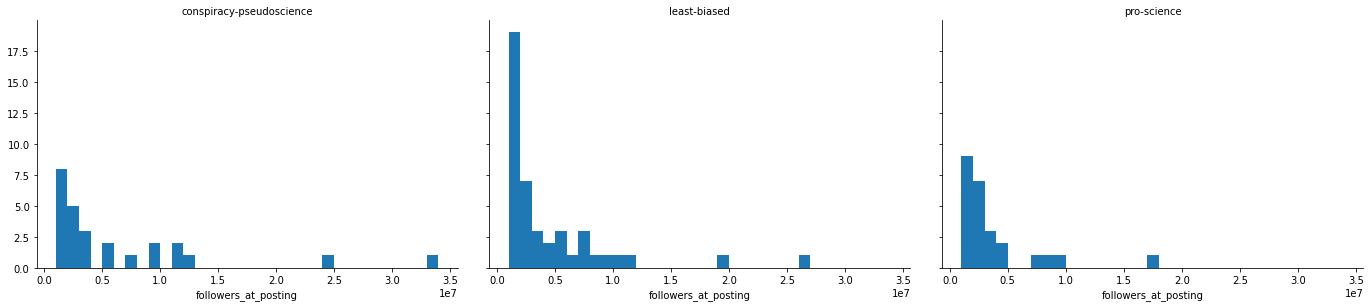

In [26]:
bins = np.arange(1000000, df_page_average['followers_at_posting'].max()+1000000, 1000000)

g = sb.FacetGrid(data = df_page_average, col = 'category', col_wrap = 3)
g.map(plt.hist, 'followers_at_posting', bins=bins)
g.set_titles('{col_name}');
g.fig.set_size_inches(20,5)

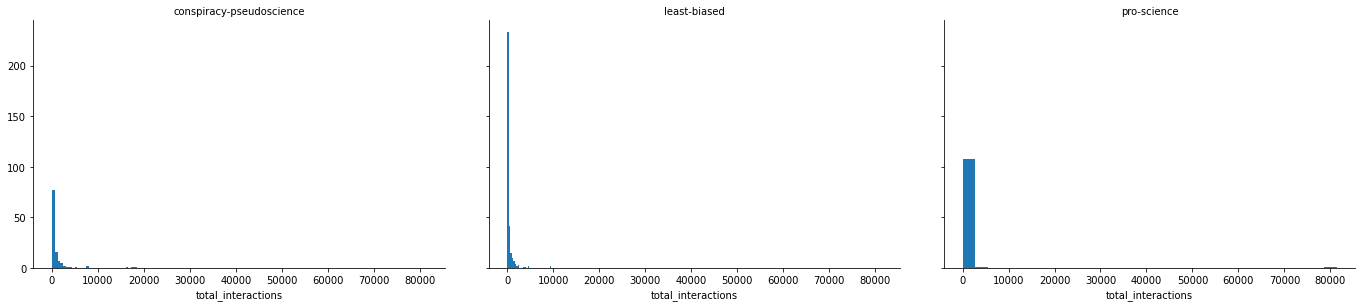

In [27]:
g = sb.FacetGrid(data = df_page_average, col = 'category', col_wrap = 3)
g.map(plt.hist, 'total_interactions', bins=30)
g.set_titles('{col_name}');
g.fig.set_size_inches(20,5)

In [28]:
df.sort_values(['total_interactions'], ascending=False).head()

,page_name,facebook_id,followers_at_posting,post_created,type,comments,shares,total_views,url,message,link,final_link,image_text,link_text,description,sponsor_name,sponsor_category,reactions,total_interactions,category
3253958,World Health Organization (WHO),154163327962392,32399726.0,2020-07-16 02:18:00,Native Video,35592,228705,132811401,https://www.facebook.com/WHO/posts/33325933434...,There are lots of things that we want to be do...,https://www.facebook.com/WHO/videos/3046493718...,NaN,NaN,We all have to play our part,NaN,NaN,NaN,2390346,2654643,pro-science
6324653,VT,363765800431935,26889703.0,2021-02-19 16:00:39,Native Video,44992,361448,68632537,https://www.facebook.com/VT/posts/441632573850...,This guy's in the process of making something ...,https://www.facebook.com/VT/videos/90137398403...,NaN,NaN,This man creates something amazing from clay!,NaN,NaN,NaN,1668237,2074677,least-biased
6139072,VT,363765800431935,26922715.0,2021-03-01 12:00:45,Native Video,27444,78032,59823980,https://www.facebook.com/VT/posts/442729037074...,This guy's taking a huge risk for the sake of ...,https://www.facebook.com/VT/videos/44029909739...,NaN,NaN,This man is risking his life to save a baby cow!,NaN,NaN,NaN,1891964,1997440,least-biased
963661,ABC 7 Chicago,165583971161,2296705.0,2019-05-06 21:20:00,Link,316,1993925,0,https://www.facebook.com/abc7chicago/posts/101...,'I'M TERRIFIED FOR MALEAH' The girl's mom says...,https://abc7chicago.com/missing-girl-may-have-...,https://abc7chicago.com/missing-girl-may-have-...,NaN,MISSING GIRL - PLEASE SHARE: 4-year-old may ha...,-,NaN,NaN,1984,1996225,least-biased
5778695,Reuters,114050161948682,5123131.0,2021-01-26 06:35:25,Native Video,20755,151008,24066377,https://www.facebook.com/Reuters/posts/4097493...,A tiny kitten was spotted feeding on milk from...,https://www.facebook.com/Reuters/videos/280574...,NaN,NaN,Kitten suckles nursing dog in Nigeria 🐕 🐱,NaN,NaN,NaN,1476935,1648698,least-biased


In [29]:
df_page_average[df_page_average['followers_at_posting']>15000000]

,category,facebook_id,followers_at_posting,comments,shares,total_views,reactions,total_interactions
79,conspiracy-pseudoscience,367116489976035,2.427896e+07,953.575650,1371.254076,1.816997e+04,5388.961953,7713.791679
104,conspiracy-pseudoscience,70630972354,3.383338e+07,130.100529,101.484669,7.701926e+02,2250.322559,2481.907757
293,least-biased,27254475167,1.911177e+07,503.818661,526.032262,2.707192e+04,3597.310456,4627.161379
323,least-biased,363765800431935,2.694637e+07,1944.853517,2595.347007,1.498084e+06,5064.336605,9604.537129
456,pro-science,154163327962392,1.738989e+07,2785.244057,6677.562599,1.072258e+06,71890.069731,81352.876387


In [30]:
df_page_average[df_page_average['total_interactions']>50000]

,category,facebook_id,followers_at_posting,comments,shares,total_views,reactions,total_interactions
456,pro-science,154163327962392,1.738989e+07,2785.244057,6677.562599,1.072258e+06,71890.069731,81352.876387


There are some outliers in the data. Some huge pages, such as the WHO, will be removed.

The threshold will be set to 1.5 million average followers and posts over 50 thousand interactions.

In [31]:
pages_to_remove = list(df_page_average[df_page_average['followers_at_posting']>15000000]['facebook_id'])

df = df[~df['facebook_id'].isin(pages_to_remove)].reset_index(drop=True)

In [32]:
pages_to_remove = list(df_page_average[df_page_average['total_interactions']>50000]['facebook_id'])

df = df[~df['facebook_id'].isin(pages_to_remove)].reset_index(drop=True)

#### Interaction per thousand followers

In [33]:
df['intactions_to_follow_ratio'] = (df['total_interactions'] / df['followers_at_posting'])*1000

### Time comparison

In [34]:
df_general_agg = df.groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})
df_general_agg

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,113,2.229384e+06,97.140621,638.247198,1156.611666,1.713626
least-biased,319,2.394905e+06,84.127738,92.201007,316.457150,0.846330
pro-science,109,1.616213e+06,30.996006,102.050224,285.828434,0.610192


In [35]:
df_2021_agg = df[df['post_created'] > '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_2021_agg

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,113,2.036399e+06,77.256850,230.846701,900.595383,1.501837
least-biased,319,2.650082e+06,91.661889,48.245603,355.158918,0.689366
pro-science,109,1.594644e+06,43.877760,95.503911,492.681618,0.805503


In [36]:
df_2020_agg = df[df['post_created'] < '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_2020_agg

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,113,2.251790e+06,99.342287,683.357332,1184.959517,1.738216
least-biased,318,2.361041e+06,83.137853,97.976514,311.372208,0.867160
pro-science,108,1.618898e+06,29.435415,102.843573,260.768284,0.585888


In [37]:
# COMPARES

for k, v in lists.items():
    ratio_2020 = df_2020_agg.loc[k]['intactions_to_follow_ratio']
    ratio_2021 = df_2021_agg.loc[k]['intactions_to_follow_ratio']
    print(k, 'ratio:', (ratio_2021-ratio_2020)/ratio_2020)
    
    follows_2020 = df_2020_agg.loc[k]['followers_at_posting']
    follows_2021 = df_2021_agg.loc[k]['followers_at_posting']
    print(k, 'follows:', (follows_2021-follows_2020)/follows_2020)
    
    print('')

least-biased ratio: -0.2050309477485604
least-biased follows: 0.1224209310838125

conspiracy-pseudoscience ratio: -0.13598935799173167
conspiracy-pseudoscience follows: -0.09565335353141116

pro-science ratio: 0.3748397706629335
pro-science follows: -0.01498179107431599



<AxesSubplot:xlabel='post_created'>

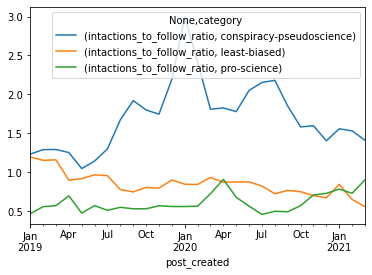

In [38]:
df.groupby('category').resample('M', on='post_created').mean()[['intactions_to_follow_ratio']].unstack(level=0).plot(kind='line')

#### Exports to Excel to make this same graph a little prettier

In [39]:
df_to_export =df.groupby('category').resample('M', on='post_created').mean()[['intactions_to_follow_ratio',
                                                                'followers_at_posting', 'reactions',
                                                                'shares', 'comments']].unstack(level=0)

df_to_export.to_excel('./data/out/time_series.xlsx')

### Vaccines and Covid analysis

This part of the analysis will focus only on posts about vaccines and covid.

In [40]:
df.columns

Index(['page_name', 'facebook_id', 'followers_at_posting', 'post_created',
       'type', 'comments', 'shares', 'total_views', 'url', 'message', 'link',
       'final_link', 'image_text', 'link_text', 'description', 'sponsor_name',
       'sponsor_category', 'reactions', 'total_interactions', 'category',
       'intactions_to_follow_ratio'],
      dtype='object')

In [41]:
df['all_texts'] = df[['message','image_text',
                                'link_text',
                                'description']].apply(
    lambda x: ','.join(x.dropna().astype(str)), axis =1)

df.head()

,page_name,facebook_id,followers_at_posting,post_created,type,comments,shares,total_views,url,message,...,image_text,link_text,description,sponsor_name,sponsor_category,reactions,total_interactions,category,intactions_to_follow_ratio,all_texts
0,Thinking Humanity,673094636084762,6349593.0,2019-02-01 23:35:00,Link,33,359,0,https://www.facebook.com/ThinkingHumanity/post...,As an excavator crashed down on a pile of cut ...,...,NaN,Heartbreaking Footage of Orangutan Trying to F...,As an excavator crashed down on a pile of cut ...,NaN,NaN,1330,1722,conspiracy-pseudoscience,0.271198,As an excavator crashed down on a pile of cut ...
1,Ancient Origins,530869733620642,654152.0,2019-02-01 23:30:07,Photo,23,172,0,https://www.facebook.com/ancientoriginsweb/pos...,"San Gens Necropolis, #Portugal www.ancient-ori...",...,NaN,Timeline Photos,NaN,NaN,NaN,410,605,conspiracy-pseudoscience,0.924862,"San Gens Necropolis, #Portugal www.ancient-ori..."
2,Collective Evolution,131929868907,5164323.0,2019-02-01 23:30:00,Photo,118,8763,0,https://www.facebook.com/CollectiveEvolutionPa...,NaN,...,"When you replace ""why is this happening to me""...",NaN,NaN,NaN,NaN,5205,14086,conspiracy-pseudoscience,2.727560,"When you replace ""why is this happening to me""..."
3,goop,221023534574471,503622.0,2019-02-01 23:25:35,Native Video,1,4,2445,https://www.facebook.com/goop/posts/2363076803...,"Celebrating those who came before us then, tho...",...,NaN,Black History Month,NaN,NaN,NaN,12,17,conspiracy-pseudoscience,0.033755,"Celebrating those who came before us then, tho..."
4,Waking Times,223015844444838,622775.0,2019-02-01 23:15:03,Link,1,30,0,https://www.facebook.com/WakingTimes/posts/212...,You may think you're getting lots of protein i...,...,NaN,10 High Protein Vegetables and if You Should C...,Many of us don't realize that we can get plent...,NaN,NaN,63,94,conspiracy-pseudoscience,0.150937,You may think you're getting lots of protein i...


In [42]:
df_vaccine = df[df['all_texts'].str.contains('vaccine|vaccination')]

<AxesSubplot:xlabel='post_created'>

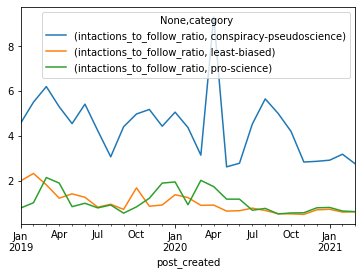

In [43]:
df_vaccine.groupby('category').resample('M', on='post_created').mean()[['intactions_to_follow_ratio']].unstack(level=0).plot(kind='line')

<AxesSubplot:xlabel='post_created'>

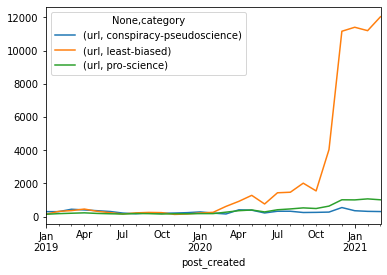

In [44]:
df_vaccine.groupby('category').resample('M', on='post_created').count()[['url']].unstack(level=0).plot(kind='line')

In [45]:
df_vaccine_agg = df_vaccine.groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_vaccine_agg

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,94,5.632335e+05,85.360418,204.430731,363.575538,4.476532
least-biased,289,1.341662e+06,103.062405,49.174773,238.795867,0.687376
pro-science,89,1.370684e+06,99.328981,90.400322,275.371180,0.897670


In [46]:
df_vaccine_agg_21 = df_vaccine[df_vaccine['post_created'] > '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_vaccine_agg_21

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,63,4.979555e+05,110.633065,155.353831,325.467742,2.947141
least-biased,270,1.235393e+06,90.351293,33.107757,220.144407,0.644188
pro-science,77,1.434698e+06,136.427651,77.524976,361.489849,0.688221


In [47]:
df_vaccine_agg_20 = df_vaccine[df_vaccine['post_created'] < '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_vaccine_agg_20

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,91,5.727174e+05,81.850623,211.246395,368.867843,4.698728
least-biased,280,1.469972e+06,118.337252,68.482383,261.209183,0.739522
pro-science,87,1.342093e+06,83.910126,95.751540,239.578757,0.991219


In [48]:
# COMPARES

for k, v in lists.items():
    ratio_2020 = df_vaccine_agg_20.loc[k]['intactions_to_follow_ratio']
    ratio_2021 = df_vaccine_agg_21.loc[k]['intactions_to_follow_ratio']
    print(k, 'ratio:', (ratio_2021-ratio_2020)/ratio_2020)
    
    shares_2020 = df_vaccine_agg_20.loc[k]['shares']
    shares_2021 = df_vaccine_agg_21.loc[k]['shares']
    print(k, 'shares:', (shares_2021-shares_2020)/shares_2020)
    
    print('')

least-biased ratio: -0.1289134174343198
least-biased shares: -0.516550744676836

conspiracy-pseudoscience ratio: -0.3727788691403627
conspiracy-pseudoscience shares: -0.26458470170750653

pro-science ratio: -0.30568180208326373
pro-science shares: -0.19035270269373356



### Mentioning Covid

In [49]:
df_covid = df[df['post_created'] > '2020-01-01']
df_covid = df_covid[df_covid['all_texts'].str.contains('covid|corona|pandemic|lockdown|sars-cov')]

<AxesSubplot:xlabel='post_created'>

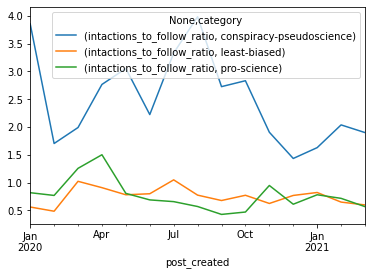

In [50]:
df_covid.groupby('category').resample('M', on='post_created').mean()[['intactions_to_follow_ratio']].unstack(level=0).plot(kind='line')

<AxesSubplot:xlabel='post_created'>

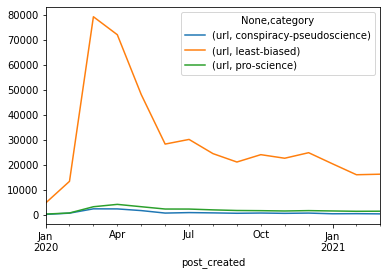

In [51]:
df_covid.groupby('category').resample('M', on='post_created').count()[['url']].unstack(level=0).plot(kind='line')

In [52]:
df_covid_agg = df_covid.groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_covid_agg

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,110,1.168563e+06,72.162321,166.083964,374.709209,2.512023
least-biased,314,1.915556e+06,108.069399,97.141499,311.592220,0.828236
pro-science,105,1.471353e+06,83.127826,170.191405,382.280189,0.849641


In [53]:
df_covid_agg_21 = df_covid[df_covid['post_created'] > '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_covid_agg_21

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,89,7.926054e+05,57.134233,89.386364,270.583807,1.857858
least-biased,296,1.763629e+06,109.959569,47.941675,314.548753,0.699868
pro-science,95,1.512431e+06,133.976201,151.944469,464.191053,0.689740


In [54]:
df_covid_agg_20 = df_covid[df_covid['post_created'] < '2021'].groupby('category').agg({'facebook_id' : 'nunique',
                            'followers_at_posting' : 'mean',
                            'comments' : 'mean',
                            'shares' : 'mean',
                            'reactions' : 'mean',
                            'intactions_to_follow_ratio' : 'mean'})

df_covid_agg_20

,facebook_id,followers_at_posting,comments,shares,reactions,intactions_to_follow_ratio
category,,,,,,
conspiracy-pseudoscience,110,1.211881e+06,73.807698,174.481337,386.109565,2.587395
least-biased,314,1.935973e+06,107.816230,103.744530,311.196378,0.845487
pro-science,105,1.463949e+06,74.063168,173.444257,367.678072,0.878460


In [55]:
# COMPARES

for k, v in lists.items():
    ratio_2020 = df_covid_agg_20.loc[k]['intactions_to_follow_ratio']
    ratio_2021 = df_covid_agg_21.loc[k]['intactions_to_follow_ratio']
    print(k, 'ratio:', (ratio_2021-ratio_2020)/ratio_2020)
    
    shares_2020 = df_covid_agg_20.loc[k]['shares']
    shares_2021 = df_covid_agg_21.loc[k]['shares']
    print(k, 'shares:', (shares_2021-shares_2020)/shares_2020)
    
    print('')

least-biased ratio: -0.17223082853926036
least-biased shares: -0.537887201359583

conspiracy-pseudoscience ratio: -0.2819580565575689
conspiracy-pseudoscience shares: -0.48770243897102883

pro-science ratio: -0.21483026034165886
pro-science shares: -0.12395791149121203

